**TensorFlow Boosted Trees**

In [1]:
# Install stasmodels library
!pip install statsmodels

## Loading the titanic dataset

In [23]:
# Import required libraries
import numpy as np
import pandas as pd
from IPython.display import clear_output
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.random.set_seed(123)

In [3]:
# Load dataset
train_data = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_data = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train_data.pop('survived')
y_eval = eval_data.pop('survived')

**Preprocess the data**

In [6]:
fc = tf.feature_column
CATEGORICAL_COLUMN = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMN = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name,vocab))
feature_column = []
for feature_name in CATEGORICAL_COLUMN:
  # Need to one-hot encode categorical features.
  vocabulary = train_data[feature_name].unique()
  feature_column.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMN:
  feature_column.append(fc.numeric_column(feature_name,dtype=tf.float32))

**Build input pipeline**

In [15]:

def make_input_fn(x, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(len(y_train))
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(len(y_train)))
    return dataset
  return input_fn


In [16]:
# Train and evaluate input functions
train_input_fn = make_input_fn(train_data, y_train)
eval_input_fn = make_input_fn(eval_data, y_eval, shuffle=False, n_epochs=2)

**Train the model**

In [17]:
# Define parameters
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  'center_bias': True
}

estimator = tf.estimator.BoostedTreesClassifier(feature_column, **params)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppfwm4ulh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
# Train model
estimator.train(train_input_fn, max_steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmppfwm4ulh/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners after saving checkp

In [20]:
# Evaluate the model
result = estimator.evaluate(eval_input_fn)
clear_output()
pd.Series(result).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.869483
auc_precision_recall,0.851343
average_loss,0.416901
label/mean,0.375000
loss,0.416901
precision,0.752688
prediction/mean,0.386502
recall,0.707071


In [22]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1

# In-memory input function does not use batching
def make_in_memory_train_input_fn(x, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(x), y
  return input_fn
train_input_fn = make_in_memory_train_input_fn(train_data, y_train)

# Train the model.
estimator_1 = tf.estimator.BoostedTreesClassifier(
    feature_column, 
    train_in_memory=True, 
    **in_memory_params)

estimator_1.train(train_input_fn)
print(estimator_1.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpc2wl0d3j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


**Model interpretation and Plotting**

In [25]:
sns_color = sns.color_palette('colorblind')

In [27]:
pred_dict = list(estimator_1.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpc2wl0d3j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [28]:
# Create Pandas dataframe
label = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dict])
dfc_df = pd.DataFrame([pred['dfc'] for pred in pred_dict])
dfc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,528.0,-0.026250,0.093296,-0.147969,-0.076613,-0.054171,0.003090,0.505813
sex,528.0,0.006601,0.107768,-0.097792,-0.074628,-0.072858,0.138226,0.182456
class,528.0,0.017165,0.092995,-0.133776,-0.043060,-0.041724,0.033055,0.231730
deck,528.0,-0.018092,0.032545,-0.094638,-0.042912,-0.032754,0.001897,0.199893
embark_town,528.0,-0.007019,0.031410,-0.056042,-0.017526,-0.015517,-0.003948,0.086491
fare,528.0,0.027099,0.089063,-0.224306,-0.028055,-0.002334,0.072627,0.285098
n_siblings_spouses,528.0,0.001386,0.025989,-0.133110,0.002419,0.003337,0.006167,0.103482
parch,528.0,0.000020,0.011422,-0.098722,0.000654,0.000864,0.001482,0.040270
alone,528.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
bias = pred_dict[0]['bias']
dfc_prob = dfc_df.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [39]:
# Visualization
def _get_color(value):
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    x_coord = ax.get_xlim()[0]
    offset = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - offset, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - offset, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  top_n = 8
  sorted_ix = example.abs().sort_values()[-top_n:].index
  example = example[sorted_ix]
  color = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[color],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)
  # Add feature values.
  _add_feature_values(eval_data.iloc[id][sorted_ix], ax)
  return ax

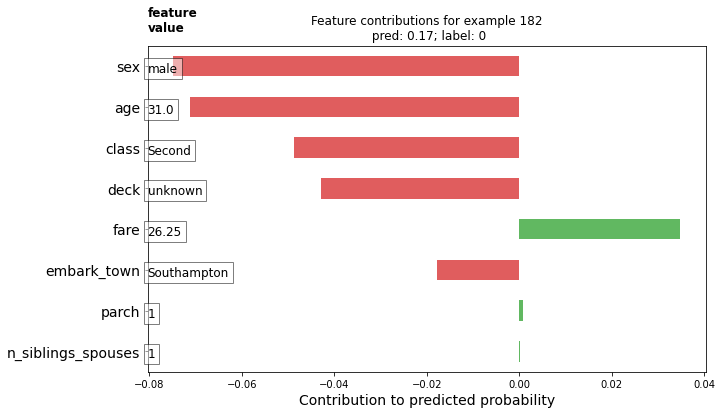

In [41]:
# Plot the results
id = 182 # record number
example = dfc_df.iloc[id] 
top_n = 8 
sorted_ix = example.abs().sort_values()[-top_n:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(id, probs[id], label[id]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

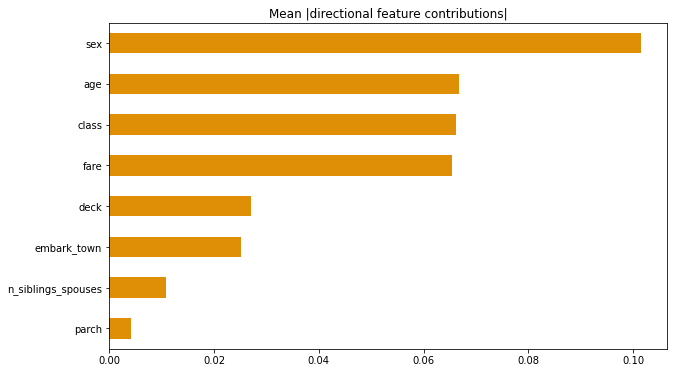

In [45]:
# Absolute DFCs
dfc_mean = dfc_df.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index 
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')